<a href="https://colab.research.google.com/github/Jules-gatete/ML-Techniques-I---CHATBOT/blob/main/chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🔧 STEP 1: Install Dependencies

In [1]:
# 🔧 STEP 1: Install Dependencies
!pip install -q transformers datasets evaluate rouge_score nltk seaborn wordcloud


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 506.8 kB/s eta 0:00:00


In [2]:
!pip install --upgrade datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

# 📦 STEP 2: Import Libraries


In [3]:
# 📦 STEP 2: Import Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re
import string
import numpy as np

from datasets import load_dataset, Dataset
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

from transformers import (
    T5Tokenizer,
    TFT5ForConditionalGeneration,
    DataCollatorForSeq2Seq,
    create_optimizer
)
import tensorflow as tf

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

# 📊 STEP 3: Load the Dataset


In [4]:
import pandas as pd

# Define file paths for the splits
splits = {
    'train': 'data/mistralSingleV4_train.json',
    'validation': 'data/mistralSingleV4_val.json',
    'test': 'data/mistralSingleV4_test.json'
}

# Load all splits using `hf://` protocol
train_df = pd.read_json("hf://datasets/abamerdeen/insurance-qa/" + splits["train"])
val_df = pd.read_json("hf://datasets/abamerdeen/insurance-qa/" + splits["validation"])
test_df = pd.read_json("hf://datasets/abamerdeen/insurance-qa/" + splits["test"])

# Merge into one DataFrame for EDA
df = pd.concat([train_df, val_df, test_df], ignore_index=True)

# Preview
print(df.info())
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3514 entries, 0 to 3513
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   context   3514 non-null   object
 1   question  3514 non-null   object
 2   answer    3514 non-null   object
dtypes: object(3)
memory usage: 82.5+ KB
None


,context,question,answer
0,,when does universal life insurance make sense?,Universal life insurance makes sense in severa...
1,,how long has whole life insurance been around?,The provided knowledge does not contain specif...
2,,how does an agent get paid on life insurance?,"According to the information provided, the ins..."
3,,can nursing home take life insurance?,", it does not appear that a nursing home can d..."
4,,can you contest the beneficiary of life insura...,", the following points can be made regarding c..."


📊 STEP 4: Exploratory Data Analysis (EDA)


In [5]:
# Fill missing values
df['question'] = df['question'].fillna("")
df['answer'] = df['answer'].fillna("")

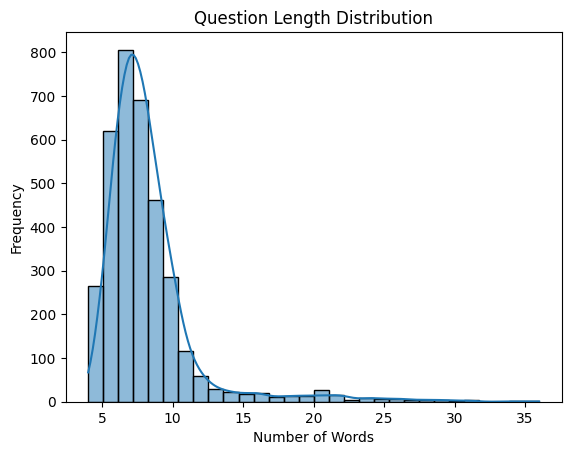

In [6]:
# ➤ Question length distribution
df['question_length'] = df['question'].apply(lambda x: len(x.split()))
sns.histplot(df['question_length'], bins=30, kde=True)
plt.title("Question Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

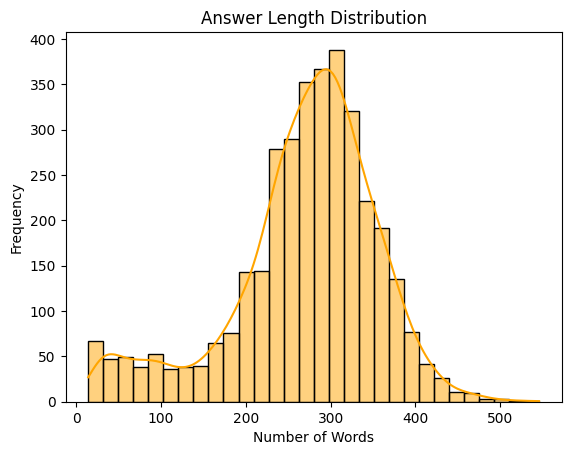

In [7]:
# ➤ Answer length distribution
df['answer_length'] = df['answer'].apply(lambda x: len(x.split()))
sns.histplot(df['answer_length'], bins=30, kde=True, color='orange')
plt.title("Answer Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

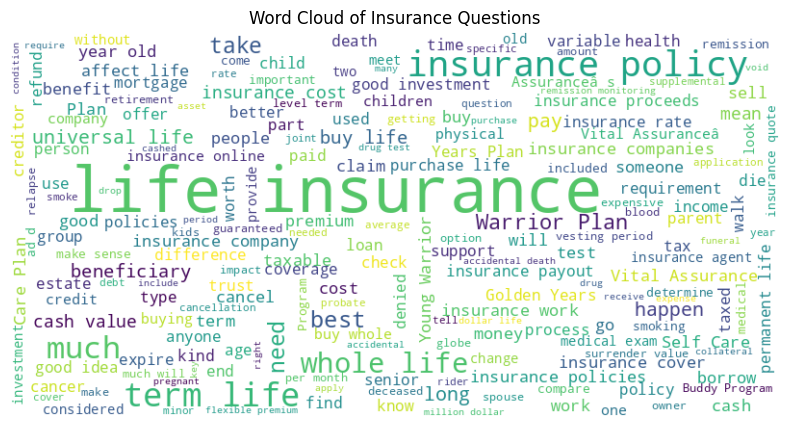

In [8]:
# ➤ Word cloud of most frequent question words
text = ' '.join(df['question'].astype(str).tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Insurance Questions")
plt.show()

In [9]:
# ➤ Top 20 frequent words (excluding stopwords)
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r"[^\w\s]", "", text.lower())  # Remove punctuation
    tokens = word_tokenize(text)
    return [word for word in tokens if word not in stop_words and word not in string.punctuation]

all_words = df['question'].apply(clean_text).explode()
freq_words = all_words.value_counts().head(20)

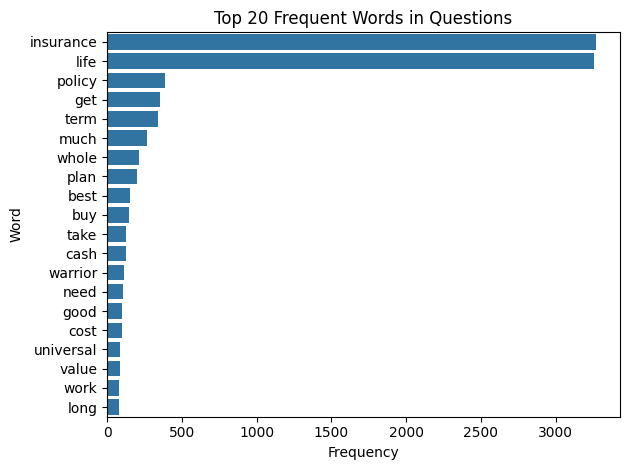

In [10]:
# Plot top 20 frequent words
sns.barplot(x=freq_words.values, y=freq_words.index)
plt.title("Top 20 Frequent Words in Questions")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.tight_layout()
plt.show()


In [11]:
# ➤ Basic Data Inspection
print("\nBasic Info:")
print(df[['question', 'answer']].isnull().sum())
print("\nSample Data:")
print(df[['question', 'answer']].sample(3))



Basic Info:
question    0
answer      0
dtype: int64

Sample Data:
                                       question  \
374      can life insurance be a tax deduction?   
1155          why do people buy life insurance?   
1452  can you cancel life insurance at anytime?   

                                                 answer  
374   The tax deductibility of life insurance premiu...  
1155  People buy life insurance for several reasons:...  
1452  Yes, you can cancel your life insurance policy...  


🔍 STEP 5: Preprocessing Function


In [12]:
# Text cleaning function
def preprocess(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with one
    text = re.sub(f"[{re.escape(string.punctuation)}]", '', text)  # Remove punctuation
    return text.strip()

In [13]:
# Apply preprocessing to both columns
df['clean_question'] = df['question'].apply(preprocess)
df['clean_answer'] = df['answer'].apply(preprocess)

# Check for any remaining missing values
print("\n🧼 Null Check After Preprocessing:")
print(df[['clean_question', 'clean_answer']].isnull().sum())

# Show samples
print("\n📌 Sample Preprocessed Data:")
print(df[['clean_question', 'clean_answer']].sample(3))



🧼 Null Check After Preprocessing:
clean_question    0
clean_answer      0
dtype: int64

📌 Sample Preprocessed Data:
                                         clean_question  \
3444  what wellness resources are included in the wa...   
2165  whats the process for canceling policies under...   
2942  will i receive a 1099 for life insurance proceeds   

                                           clean_answer  
3444  the warrior plan includes a variety of wellnes...  
2165  im so sorry to hear that youre going through a...  
2942  the taxation of life insurance proceeds is not...  


🧠 STEP 6: Tokenization & Dataset Preparation


In [14]:
from datasets import Dataset
from transformers import T5Tokenizer

# Load tokenizer (T5-small, no legacy mode)
tokenizer = T5Tokenizer.from_pretrained("t5-small", legacy=False)

# Set max lengths
max_input_length = 64
max_target_length = 128

# Define tokenization function
def tokenize_function(example):
    # T5 expects inputs with a task prefix, like "question: "
    input_texts = ["question: " + q for q in example["clean_question"]]
    target_texts = example["clean_answer"]

    model_inputs = tokenizer(
        input_texts,
        max_length=max_input_length,
        padding="max_length",
        truncation=True
    )

    # Tokenize targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            target_texts,
            max_length=max_target_length,
            padding="max_length",
            truncation=True
        )

    # Replace pad token ids in labels with -100 to ignore in loss
    labels["input_ids"] = [
        [(token if token != tokenizer.pad_token_id else -100) for token in label]
        for label in labels["input_ids"]
    ]

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

In [15]:
# Drop any NaN just in case
df = df.dropna(subset=['clean_question', 'clean_answer']).reset_index(drop=True)

# Convert to Hugging Face Dataset
hf_dataset = Dataset.from_pandas(df[['clean_question', 'clean_answer']])

# Split dataset into training and validation
split_dataset = hf_dataset.train_test_split(test_size=0.1, seed=42)
train_ds = split_dataset['train']
val_ds = split_dataset['test']

# Tokenize both splits
tokenized_train_ds = train_ds.map(tokenize_function, batched=True, remove_columns=['clean_question', 'clean_answer'])
tokenized_val_ds = val_ds.map(tokenize_function, batched=True, remove_columns=['clean_question', 'clean_answer'])

# Sanity check
print("✅ Sample tokenized entry:")
print(tokenized_train_ds[0])


Map:   0%|          | 0/3162 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3959: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/352 [00:00<?, ? examples/s]

✅ Sample tokenized entry:
{'input_ids': [822, 10, 149, 405, 8, 1044, 124, 515, 2454, 307, 1987, 533, 6867, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'labels': [8, 1044, 124, 515, 2454, 7, 307, 1987, 533, 6867, 190, 633, 843, 12009, 876, 12, 2519, 20561, 533, 758, 11, 5086, 4026, 1112, 21, 1742, 28, 686, 204, 8363, 14672, 120, 8, 515, 19, 14039, 300, 18249, 6683, 24, 1457, 3008, 12, 1961, 46, 3, 107, 115, 9, 536, 75, 593, 13, 431, 42, 666, 48, 2404, 533, 3, 7959, 4657, 38, 3, 9, 15705, 21, 1231, 8363, 758, 57, 16, 3728, 23, 7302, 53, 1742, 12, 1984, 11, 12666, 48, 593, 8, 1044, 124, 515, 18198, 7, 1291, 5235, 7, 12, 4082, 16, 1646, 533, 4891, 11, 4693, 11960, 8966, 8, 

📦 STEP 7: Prepare Dataset for TensorFlow


🏋️‍♂️ STEP 8: Train the Model

In [16]:
def gen(dataset):
    for example in dataset:
        yield {
            "input_ids": example["input_ids"],
            "attention_mask": example["attention_mask"],
            "labels": example["labels"]
        }


In [17]:
output_signature = {
    "input_ids": tf.TensorSpec(shape=(None,), dtype=tf.int32),
    "attention_mask": tf.TensorSpec(shape=(None,), dtype=tf.int32),
    "labels": tf.TensorSpec(shape=(None,), dtype=tf.int32)
}


In [18]:
BATCH_SIZE = 8

import tensorflow as tf  # Make sure this is TensorFlow's Dataset

tf_train_dataset = tf.data.Dataset.from_generator(
    lambda: gen(tokenized_train_ds),
    output_signature=output_signature
).padded_batch(BATCH_SIZE, padding_values={
    # The padding values should match the structure of the output_signature and gen()
    "input_ids": 0,
    "attention_mask": 0,
    # Labels are typically padded with -100 as per Hugging Face practice for loss calculation
    "labels": -100
})

tf_val_dataset = tf.data.Dataset.from_generator(
    lambda: gen(tokenized_val_ds),
    output_signature=output_signature
).padded_batch(BATCH_SIZE, padding_values={
    # The padding values should match the structure of the output_signature and gen()
    "input_ids": 0,
    "attention_mask": 0,
    # Labels are typically padded with -100 as per Hugging Face practice for loss calculation
    "labels": -100
})

In [19]:
num_train_steps = tf.data.experimental.cardinality(tf_train_dataset).numpy() * 5
optimizer, schedule = create_optimizer(init_lr=3e-4, num_warmup_steps=0, num_train_steps=num_train_steps)
steps_per_epoch = tf.data.experimental.cardinality(tf_train_dataset).numpy()

# Load the T5 model
from transformers import TFT5ForConditionalGeneration
model = TFT5ForConditionalGeneration.from_pretrained("t5-small")

model.compile(optimizer=optimizer)  # No need to manually set loss

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# ✅ Apply patch BEFORE creating EarlyStopping
EarlyStopping._implements_train_batch_hooks = lambda self: False
EarlyStopping._implements_test_batch_hooks = lambda self: False
EarlyStopping._implements_predict_batch_hooks = lambda self: False

# ✅ Now create the callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

# ✅ Proceed to training
history = model.fit(
    tf_train_dataset,
    validation_data=tf_val_dataset,
    epochs=5,
    callbacks=[early_stopping]
)


Epoch 1/5
     32/Unknown - 333s 10s/step - loss: 6.5890

In [22]:
model.save_pretrained("t5_insurance_chatbot_model")
tokenizer.save_pretrained("t5_insurance_chatbot_model")


('t5_insurance_chatbot_model/tokenizer_config.json',
 't5_insurance_chatbot_model/special_tokens_map.json',
 't5_insurance_chatbot_model/spiece.model',
 't5_insurance_chatbot_model/added_tokens.json')

In [23]:
# Inspect the structure of a single batch
for example in tf_val_dataset.take(1):
    print("Type:", type(example))
    print("Keys:", example.keys() if isinstance(example, dict) else "Not a dict")
    break


Type: <class 'dict'>
Keys: dict_keys(['input_ids', 'attention_mask', 'labels'])


In [24]:
# Function to decode generated prediction IDs
def decode_preds(pred_ids):
    return tokenizer.batch_decode(pred_ids, skip_special_tokens=True)

# Function to decode ground truth labels, handling -100 padding
def decode_labels(labels):
    # Replace -100 with the pad_token_id before decoding
    # Ensure labels are in a format suitable for numpy conversion
    labels_np = labels.numpy() if isinstance(labels, tf.Tensor) else np.array(labels)
    labels_np = np.where(labels_np == -100, tokenizer.pad_token_id, labels_np)
    return tokenizer.batch_decode(labels_np, skip_special_tokens=True)

# Get predictions and labels
predictions = []
references = []

for batch in tf_val_dataset.take(10):
    inputs = batch
    labels = inputs["labels"]

    pred_ids = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_length=128,
        num_beams=4,
        early_stopping=True
    )

    decoded_preds = decode_preds(pred_ids)
    decoded_labels = decode_labels(labels)

    predictions.extend(decoded_preds)
    references.extend([[label] for label in decoded_labels])  # BLEU expects nested list

In [ ]:
!pip install evaluate bert_score


In [ ]:
import evaluate
import numpy as np

# Load metrics
bleu = evaluate.load("bleu")
f1 = evaluate.load("f1")

# Decode function
def decode_preds(pred_ids):
    return tokenizer.batch_decode(pred_ids, skip_special_tokens=True)

def decode_labels(labels):
    return tokenizer.batch_decode(labels, skip_special_tokens=True)

# Store results
predictions = []
references = []

# Run inference on a small sample
for batch in tf_val_dataset.take(10):
    inputs = {k: v for k, v in batch.items() if k != "labels"}
    labels = batch["labels"]

    # Generate predictions
    pred_ids = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_length=128,
        num_beams=4,
        early_stopping=True
    )

    decoded_preds = decode_preds(pred_ids)
    decoded_labels = decode_labels(labels)

    predictions.extend(decoded_preds)
    references.extend([[label] for label in decoded_labels])  # BLEU expects nested list

# Compute BLEU
bleu_score = bleu.compute(predictions=predictions, references=references)
print(f"🌐 BLEU Score: {bleu_score['bleu']:.4f}")

# Compute F1
f1.add_batch(
    predictions=[p.split() for p in predictions],
    references=[r[0].split() for r in references]
)
f1_score = f1.compute(average="macro")
print(f"🎯 F1 Score: {f1_score['f1']:.4f}")


In [ ]:
import evaluate

# Load advanced metrics
rouge = evaluate.load("rouge")
meteor = evaluate.load("meteor")
bertscore = evaluate.load("bertscore")

# 🧠 Compute ROUGE, METEOR, BERTScore
rouge_result = rouge.compute(predictions=predictions, references=[r[0] for r in references])
meteor_result = meteor.compute(predictions=predictions, references=[r[0] for r in references])
bertscore_result = bertscore.compute(predictions=predictions, references=[r[0] for r in references], lang="en")

# 📊 Display results
print("📝 ROUGE-L:", f"{rouge_result['rougeL']:.4f}")
print("🔁 METEOR:", f"{meteor_result['meteor']:.4f}")
print("🧠 BERTScore (F1 mean):", f"{np.mean(bertscore_result['f1']):.4f}")


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import evaluate
from tqdm import tqdm

# Load metrics
bleu_metric = evaluate.load("bleu")
rouge_metric = evaluate.load("rouge")
f1_metric = evaluate.load("f1")


# decode predictions
def generate_answers(batch):
    inputs = tokenizer(batch["clean_question"], return_tensors="tf", padding=True, truncation=True)
    output_sequences = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_length=128
    )
    return tokenizer.batch_decode(output_sequences, skip_special_tokens=True)

# Prepare ground truth and predictions
predictions = []
references = []

# Loop through validation examples
for example in tqdm(val_ds, desc="Evaluating"):
    pred = generate_answers({"clean_question": example["clean_question"]})[0]
    ref = example["clean_answer"]

    predictions.append(pred)
    references.append(ref)


✅ 4. 📊 Compute Metrics

#BLEU



In [ ]:
bleu_result = bleu_metric.compute(predictions=predictions, references=[[ref] for ref in references])
print("BLEU Score:", bleu_result["bleu"])

##ROUGE

In [ ]:
rouge_result = rouge_metric.compute(predictions=predictions, references=references)
print("ROUGE-L:", rouge_result["rougeL"])

##F1
Note: evaluate’s F1 is for classification tasks. For Q&A, we compute token-level F1 manually: